# Mammen and Polonik + Regular Variation

#### Jimmy Butler, June 2024

Notebook to explore strategies to use regular variation to estimate the survival function in the far-reaches of the distribution's support, to be used in Mammen and Polonik.

In [5]:
# load packages
library(ggplot2)
library(dplyr)
library(mvtnorm)
library(data.table)
library(gridExtra)
library(FNN)

# load perlmutter scratch filepath signature
perlpath <- Sys.getenv('PSCRATCH')

# load self-made functions
source('~/isolines_uq/scripts/R/auxiliary_scripts/distributionIsolines.R')
source('~/isolines_uq/scripts/R/auxiliary_scripts/utils.R')

Write a little intro/motivation/outline of what you're attempting to do here.

## Toy Data

In [10]:
# transform data to have unit Frechet marginals, as in Cooley
n <- 1000
bivt_dat <- data.frame(rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))
unif_dat <- data.frame(X1=pt(bivt_dat[,1], df=4), X2=pt(bivt_dat[,2], df=4))
frec_dat <- -1/log(unif_dat)

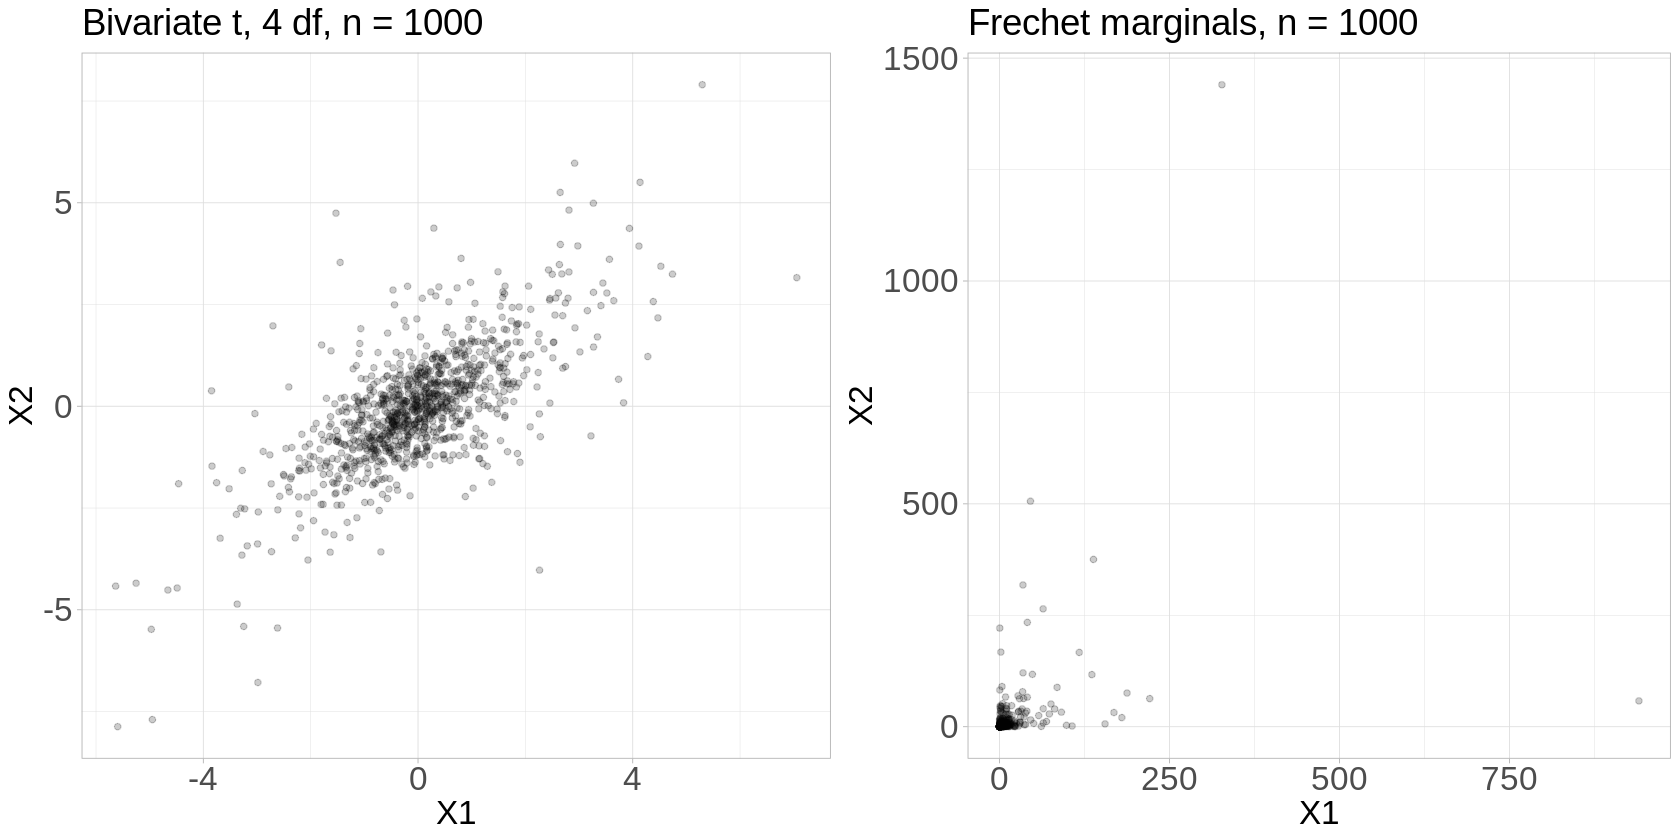

In [4]:
options(repr.plot.width=14, repr.plot.height=7, scipen=999)

plt1 <- ggplot() + 
geom_point(data=bivt_dat, aes(x=X1, y=X2), alpha=0.2) + 
ggtitle(paste0('Bivariate t, 4 df, n = ', n)) + 
theme_light() +
theme(axis.title = element_text(size = 20), 
      axis.text = element_text(size = 20), 
      text = element_text(size = 20),
      plot.title = element_text(size=22))

plt2 <- ggplot() + 
geom_point(data=frec_dat, aes(x=X1, y=X2), alpha=0.2) + 
ggtitle(paste0('Frechet marginals, n = ', n)) + 
theme_light() +
theme(axis.title = element_text(size = 20), 
      axis.text = element_text(size = 20), 
      text = element_text(size = 20),
      plot.title = element_text(size=22))

grid.arrange(plt1, plt2, ncol=2)

## Constructing a survival function estimate

In [14]:
# desired grid on which to draw
lbs <- c(0,0)
ubs <- c(200,200)
gticks <- 400
grid <- expand.grid(X1=seq(lbs[1], ubs[1], length.out=gticks), 
                   X2=seq(lbs[2], ubs[2], length.out=gticks))

# not-too-small, not-too-large probabiltiy
# if empirical survival function returns something smaller, use RV instead
q <- 0.05
# the desired isoline exceedance probability
p <- 0.01

In [6]:
# function to find the angle corresponding to a specific point in the cartesian grid
drawEmpiricalIsoline <- function(dat, angles, p) {
    
    survivalDiff <- function(r, theta, p, dat) {
        
        xPt <- r*cos(theta)
        yPt <- r*sin(theta)
        
        actual_survival <- mean((dat[,1] > xPt) & dat[,2] > yPt)
        
        return(actual_survival - p)
        }
    
    maxX <- max(dat[,1])
    maxY <- max(dat[,2])
    maxRad <- sqrt(maxX**2 + maxY**2)
    
    num_radii <- length(angles)
    
    radii <- rep(NA, num_radii)
    
    for (i in 1:num_radii) {
        radii[i] <- uniroot(survivalDiff, interval=c(0, maxRad), theta=angles[i], dat=dat, p=p)$root
    }
    
    xs <- radii*cos(angles)
    ys <- radii*sin(angles)
    
    return(data.frame(X1=xs, X2=ys, r=radii, theta=angles))
}

In [42]:
# function to evaluate survival function across a grid, incorporating both empirical survfunc and regular variation
# seems like a strategy would be use nearest-neighbor interpolation, a la https://stackoverflow.com/questions/30262434/interpolate-values-from-a-grid-efficiently-in-r
# whether nearest neighbor interpolation makes sense is another story...
# returns the q-isoline as well if you are not interpolating on another grid

evaluateSurvivalGrid <- function(dat, q, emp_ticks, num_angles, num_radii, interp_grid=NULL) {
    
    # first, find the q_isoline
    angles <- seq(0, pi/2, length.out=num_angles)
    q_isoline <- drawEmpiricalIsoline(dat, angles, q)
    # get upper bounds for grid on which you will evaluate empirical survival function
    # 50 is arbitrary, just some extra padding
    ub <- max(q_isoline[1,1], tail(q_isoline, 1)[1,2]) + 50
    
    # make the grid and evaluate empirical survival function on it
    # subsetting the points for which exceedance probability is at least q
    grid <- expand.grid(X1=seq(0, ub, length.out=emp_ticks), 
                   X2=seq(0, ub, length.out=emp_ticks))
    
    surv_func <- fastEmpSurv(grid, dat)
    empirical_mask <- surv_func >= q
    empirical_gridpts <- grid[empirical_mask,]
    survfunc <- surv_func[empirical_mask]
    survgrid <- cbind(empirical_gridpts, survfunc)
    
    # now specify how far out you wish to draw the regularly-varying portion of the survival function
    # this is rather arbitrary and I wish to eventually make this data-dependent
    max_x <- 500
    max_y <- 500
    max_r <- sqrt(max_x**2 + max_y**2)
    
    # next, for each angle/intersecting ray of the q_isoline, estimate survfunc using RV for several radii along the ray
    surv_rays <- vector(mode='list', length=length(angles))

    for (i in 1:nrow(q_isoline)) { 
        theta <- q_isoline$theta[i]
        starting_r <- q_isoline$r[i]
        ray_radii <- seq(starting_r, max_r, length.out=num_radii+1)[-1]
        ray_probs <- (starting_r/ray_radii)*q 
        surv_rays[[i]] <- data.frame(X1=ray_radii*cos(theta), X2=ray_radii*sin(theta), survfunc=ray_probs)
    
    }

    # concatenate the empirical and RV parts into single dataframe
    full_survgrid <- rbind(survgrid, bind_rows(surv_rays))
    full_res <- list()
    
    # use nearest neighbor interpolation to interpolate onto grid, if desired, and return that interpolation
    if (!is.null(interp_grid)) {
        interp_res <- get.knnx(data=full_survgrid[,c(1,2)], query=interp_grid, k=1)
        survfunc <- full_survgrid[as.vector(interp_res$nn.index),3]
        full_interp_res <- cbind(interp_grid, survfunc)
        full_res$full_survgrid_interpolated <- full_interp_res
    }
    
    full_res$q_isoline <- q_isoline
    full_res$full_survgrid <- full_survgrid
    
    return(full_res)
}

In [55]:
num_angles <- 100
num_radii <- 100
gticks <- 200
survfunc <- evaluateSurvivalGrid(frec_dat, 50/nrow(frec_dat), gticks, num_angles, num_radii)

Warning message:
“Removed 2631 rows containing missing values (`geom_point()`).”


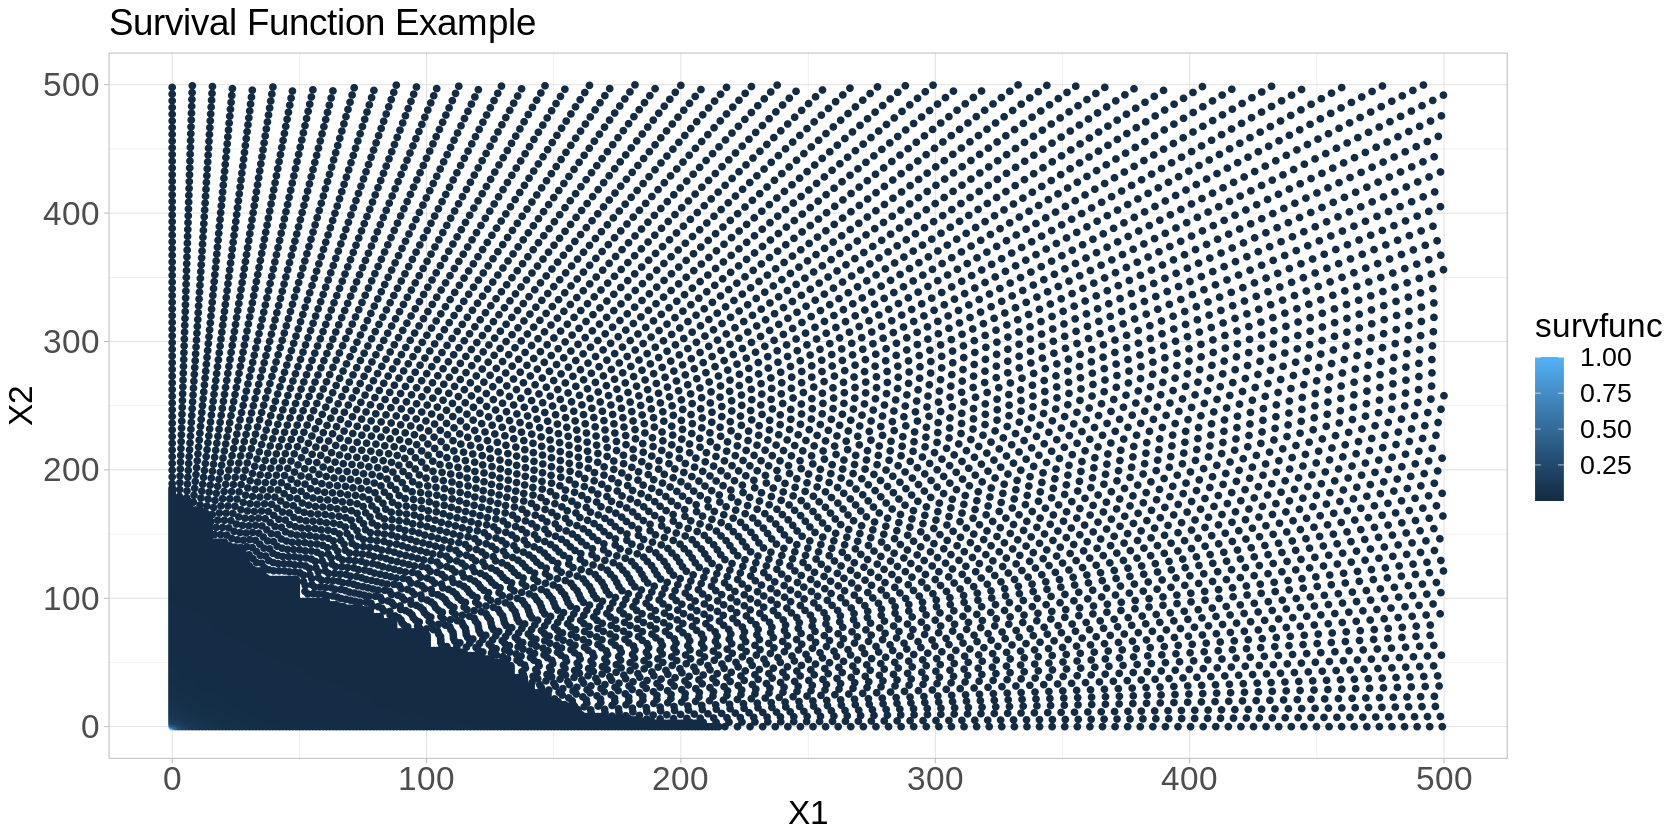

In [56]:
ggplot() + geom_point(data=survfunc$full_survgrid, aes(x=X1, y=X2, color=survfunc)) + xlim(c(0,500)) + ylim(c(0,500)) + ggtitle('Survival Function Example') + theme_light() +
theme(axis.title = element_text(size = 20), 
      axis.text = element_text(size = 20), 
      text = element_text(size = 20),
      plot.title = element_text(size=22))

## Drawing a Region

In [25]:
# function to evaluate the survival probability of a point in polar coords using this blended method
# must input a radius for a corresponding point on the desired q_isoline, which shares the same theta
### questionable if i even need this, since desired level set radii can be computed analytically
evaluateSurvivalPointDiff <- function(r, dat, q, theta, q_iso_r, lvlset) {
    
    x <- r*cos(theta)
    y <- r*sin(theta)
    empirical_prob <- mean(dat[,1] > x & dat[,2] > y)
    
    if (empirical_prob >= q) { 
        return(empirical_prob - lvlset) 
    }
    
    rv_prob <- (q_iso_r/r)*q
    return(rv_prob - lvlset)
    
}

In [165]:
# now, rewrite how to draw the tube bound given a bhat and a means of computing the survival function
drawExtremeTubeBound <- function(dat, q, q_isoline, lvlset) {

    numCoords <- length(q_isoline$r)
    radii <- rep(NA, numCoords)
    angles <- q_isoline$theta
    # 50 is arbitrary, just some padding
    maxRad <- max((q_isoline$r)*(q/lvlset)) + 50
    
    for (i in 1:numCoords) {
        # note: may need to pay attention to the fact that this is not a continuous function..
        angle <- angles[i]
        radii[i] <- uniroot(evaluateSurvivalPointDiff, interval=c(0, maxRad), dat=dat, q=q, theta=angle, q_iso_r=q_isoline$r[i], lvlset=lvlset)$root
        
    }
    
    xs <- radii*cos(angles)
    ys <- radii*sin(angles)
    
    tube <- data.frame(X1=xs, X2=ys, r=radii, theta=angles)
    
    return(tube)
    
}

In [173]:
drawExtremeTubeBounds <- function(dat, bnhat, p, q, q_isoline) {

    lvlset_top <- p - bnhat
    lvlset_bottom <- p + bnhat
    
    # by default, tube is unbounded up and to the right
    tube_top <- 'unbounded'
    
    # if not, actually find the upper bound of the tube
    if (lvlset_top > 0) { 
        tube_top <- drawExtremeTubeBound(dat, q, q_isoline, lvlset_top)
        print('hi')
    }
    
    tube_bottom <- drawExtremeTubeBound(dat, q, q_isoline, lvlset_bottom)

    tube_bounds <- list()
    tube_bounds$top <- tube_top
    tube_bounds$bottom <- tube_bottom

    return(tube_bounds)

}

In [64]:
drawExtremeRegions <- function(dat, emp_grid_ticks, alphas, ps, beta_funcs_dict, B, num_angles, num_radii) {
    # Function to draw one or more uncertainty regions for some base isoline of a specified
    # exceedence probability (p). Uses the methods in Mammen and Polonik (2013)
    # and also blends a bit of the code from Cooley.
    #
    # Arguments:  
    
    # get all combinations of p and beta functions
    beta_func_labs <- names(beta_funcs_dict)
    combos <- expand.grid(beta_func_labs=beta_func_labs, ps=ps)
    p_beta_lst <- vector(mode='list', length=nrow(combos))
    # start list of names
    names <- c()
    
    # choose the starting q, to be a function of n
    # for now, chosen such that we have on average 50 joint exceedances per point on isoline
    q <- 100/nrow(dat)
    
    # evaluate survival function on whole dataset
    main_surv_res <- evaluateSurvivalGrid(dat, q, emp_grid_ticks, num_angles, num_radii)
    main_surv_grid <- main_surv_res$full_survgrid
    q_isoline <- main_surv_res$q_isoline

    # for each p-beta function combo, get the hhat values, the boolean mask for
    # the points in Delta, and preallocate the bootstrap list of Zs
    # (all in the language of Mammen and Polonik (2013))
    for (i in 1:nrow(combos)) {
        p <- combos$ps[i]
        beta_func_lab <- combos$beta_func_labs[i]

        hhat_vals <- -main_surv_grid$survfunc + p
        # boolean mask to extract points in blown up boundary around est isoline
        deltamask <- abs(hhat_vals) <= beta_funcs_dict[[beta_func_lab]](nrow(dat))
        Zs <- rep(0, B)
        lst <- list(hhat_vals=hhat_vals, deltamask=deltamask, Zs=Zs)
        names <- c(names, paste0('beta', beta_func_lab, '_p', p))
        p_beta_lst[[i]] <- lst
    }
    names(p_beta_lst) <- names

    # for every bootstrap resample
    for (i in 1:B) {
        
        boot_dat <- dat %>% sample_frac(1, replace = TRUE)
        boot_surv_grid <- evaluateSurvivalGrid(boot_dat, q, emp_grid_ticks, num_angles, num_radii, main_surv_grid[,c(1,2)])
        
        # for every p-beta combo, get the bootstrap distribution of Z(beta)
        for (j in 1:nrow(combos)) {
            p <- combos$ps[j]
            deltamask <- p_beta_lst[[j]]$deltamask
            hhat_vals <- p_beta_lst[[j]]$hhat_vals 
            boot_hhat_vals <- -boot_surv_grid$full_survgrid_interpolated$survfunc + p

            p_beta_lst[[j]]$Zs[i] <- max(abs((boot_hhat_vals - hhat_vals)[deltamask]))
        }
    }
    # create lists of output confidence regions
    output_lst <- list()
    # labels for the output list
    newnames <- c()
    # index counter variable
    k <- 1

    # for every p-beta combo
    for (i in 1:length(p_beta_lst)) {

        name <- names(p_beta_lst)[i]
        Zs <- p_beta_lst[[i]]$Zs
        hhat_vals <- p_beta_lst[[i]]$hhat_vals

        # for every p-beta-alpha triple, draw confidence regions and store results
        for (j in 1:length(alphas)) {
            alpha <- alphas[j]
            bhat <- as.numeric(quantile(Zs, probs = 1 - alpha))
            #tube_bounds <- drawExtremeTubeBounds(dat, bhat, combos$ps[i], q, q_isoline)
            out <- list()
            #out$tube_top <- tube_bounds$top
            #out$tube_bottom <- tube_bounds$bottom
            out$alpha <- alpha
            out$p <- combos$ps[i]
            out$bhat <- bhat
            out$B <- B
            out$beta_func <- combos$beta_func_labs[i]
            out$beta_function <- beta_funcs_dict[[combos$beta_func_labs[i]]]
            
            newnames <- c(newnames, paste0(name, '_alpha', alpha))
            output_lst[[k]] <- out
            # update counter
            k <- k+1
        }
    }
    # label the list elements for easier bookkeeping
    names(output_lst) <- newnames

    output_lst$data <- dat

    return(output_lst)
}

In [78]:
# transform data to have unit Frechet marginals, as in Cooley
n <- 5000
bivt_dat <- data.frame(rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))
unif_dat <- data.frame(X1=pt(bivt_dat[,1], df=4), X2=pt(bivt_dat[,2], df=4))
frec_dat <- -1/log(unif_dat)

In [79]:
B <- 500
alphas <- c(0.05)
ps <- c(0.001)
beta_funcs_dict <- list()
beta_funcs_dict[[as.character(1/2)]] <- function(n) {return((1/n)^(1/2))}

num_angles <- 100
num_radii <- 100
gticks <- 200

test_regions <- drawExtremeRegions(frec_dat, gticks, alphas, ps, beta_funcs_dict, B, num_angles, num_radii)

Notes: seems like bhat is always similar regardless of p, like it's sample size dependent..

In [40]:
ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/0.005_prob/5000_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)
confreg_lab <- 'beta0.5_p0.005_alpha0.05'
#isoline <- drawBivGaussIsoline(numCoords=500, gridUbs=c(3,3), gridLbs=c(-1,-1), prob=0.01)

Warning message:
“Removed 31 rows containing missing values (`geom_point()`).”


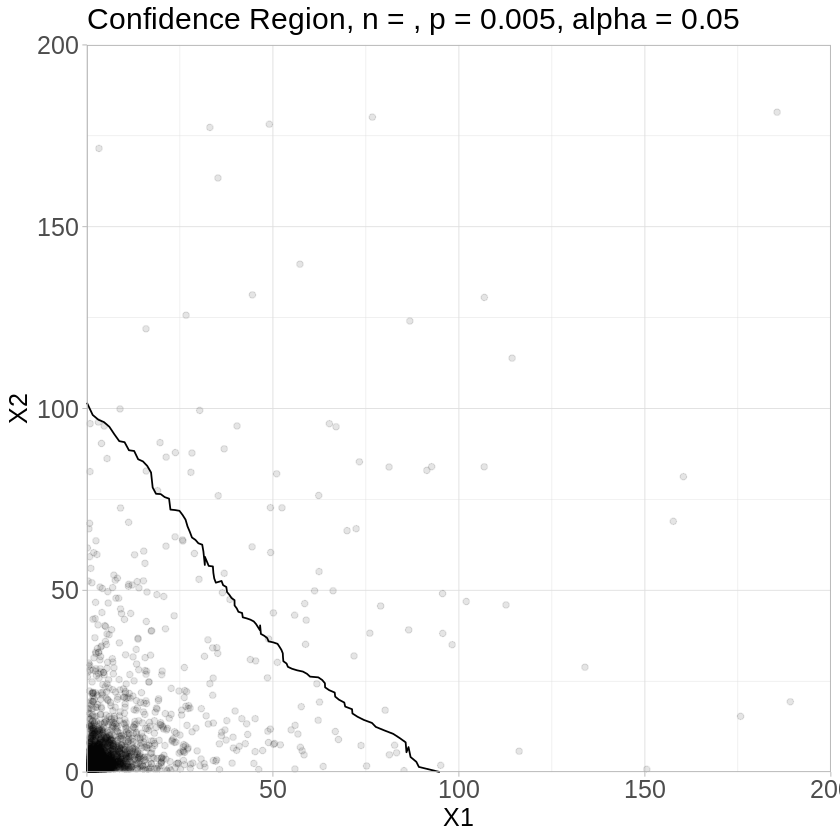

In [43]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

#polygon <- rbind(confregs[[confreg_lab]]$tube_bounds$top, 
#                 data.frame(t(rev(data.frame(t(confregs[[confreg_lab]]$tube_bounds$bottom))))))
n <- nrow(confregs[[confreg_lab]]$data)
p <- confregs[[confreg_lab]]$p
alpha <- confregs[[confreg_lab]]$alpha

ggplot() + geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
#geom_line(data=confregs[[confreg_lab]]$tube_bounds$top, aes(x=X1, y=X2)) +
geom_line(data=confregs[[confreg_lab]]$tube_bounds$bottom, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
#geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,200), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,200), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

In [42]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

bivt_top <- data.frame(X1=qt(exp(-1/frec_top)$X1, 4), X2=qt(exp(-1/frec_top)$X2, 4))
bivt_bottom <- data.frame(X1=qt(exp(-1/frec_bottom)$X1, 4), X2=qt(exp(-1/frec_bottom)$X2, 4))
isoline <- drawBivtIsoline(numCoords=100, gridUbs=c(10,10), gridLbs=c(-2,-2), prob=0.005)

n <- nrow(confregs$data)
p <- confregs[[confreg_lab]]$p
alpha <- confregs[[confreg_lab]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
geom_line(data=bivt_top, aes(x=X1, y=X2)) +
geom_line(data=bivt_bottom, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,10), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,10), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

ERROR: Error in confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100), c(1, 2)]: incorrect number of dimensions


In [33]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

confreg_lab <- 'beta0.5_p0.01_alpha0.05'

frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

bivt_top <- data.frame(X1=qt(exp(-1/frec_top)$X1, 4), X2=qt(exp(-1/frec_top)$X2, 4))
bivt_bottom <- data.frame(X1=qt(exp(-1/frec_bottom)$X1, 4), X2=qt(exp(-1/frec_bottom)$X2, 4))
isoline <- drawBivtIsoline(numCoords=100, gridUbs=c(5,5), gridLbs=c(-2,-2), prob=0.01)

n <- nrow(confregs$data)
p <- confregs[[confreg_lab]]$p
alpha <- confregs[[confreg_lab]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
geom_line(data=bivt_top, aes(x=X1, y=X2)) +
geom_line(data=bivt_bottom, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,15), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,15), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

ERROR: Error in exp(-1/frec_top)$X1: $ operator is invalid for atomic vectors


Warning message:
“Removed 28 rows containing missing values (`geom_line()`).”


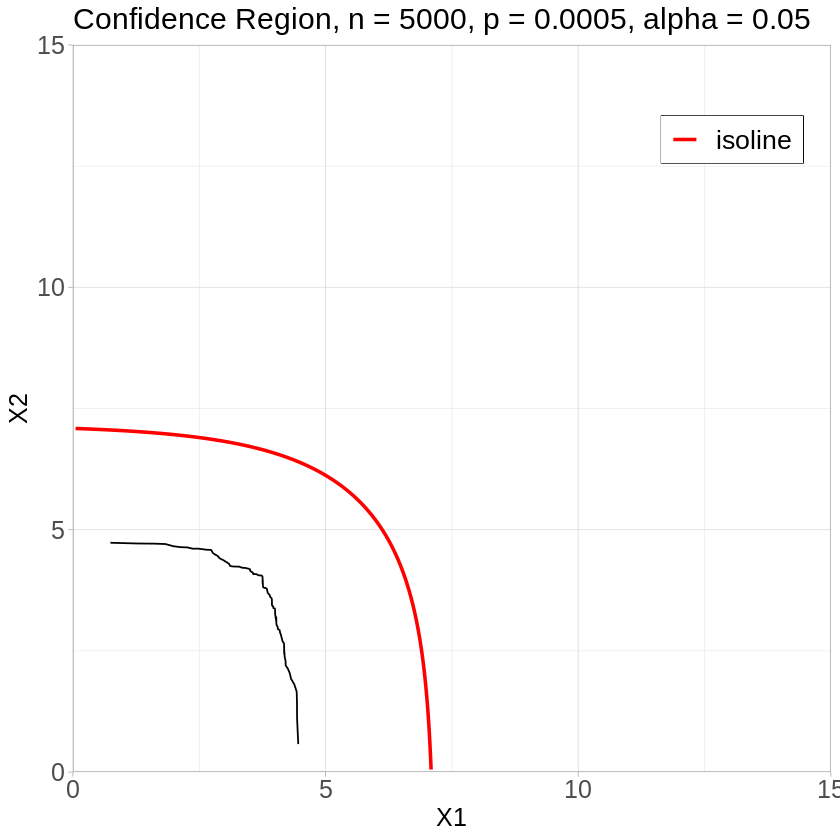

In [166]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

confreg_lab <- 'beta0.5_p5e-04_alpha0.05'

#frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

#bivt_top <- data.frame(X1=qt(exp(-1/frec_top)$X1, 4), X2=qt(exp(-1/frec_top)$X2, 4))
bivt_bottom <- data.frame(X1=qt(exp(-1/frec_bottom)$X1, 4), X2=qt(exp(-1/frec_bottom)$X2, 4))
isoline <- drawBivtIsoline(numCoords=100, gridUbs=c(20,20), gridLbs=c(-2,-2), prob=0.001)

n <- nrow(confregs$data)
p <- confregs[[confreg_lab]]$p
alpha <- confregs[[confreg_lab]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
#geom_line(data=bivt_top, aes(x=X1, y=X2)) +
geom_line(data=bivt_bottom, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,15), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,15), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

In [57]:
isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.0001)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))

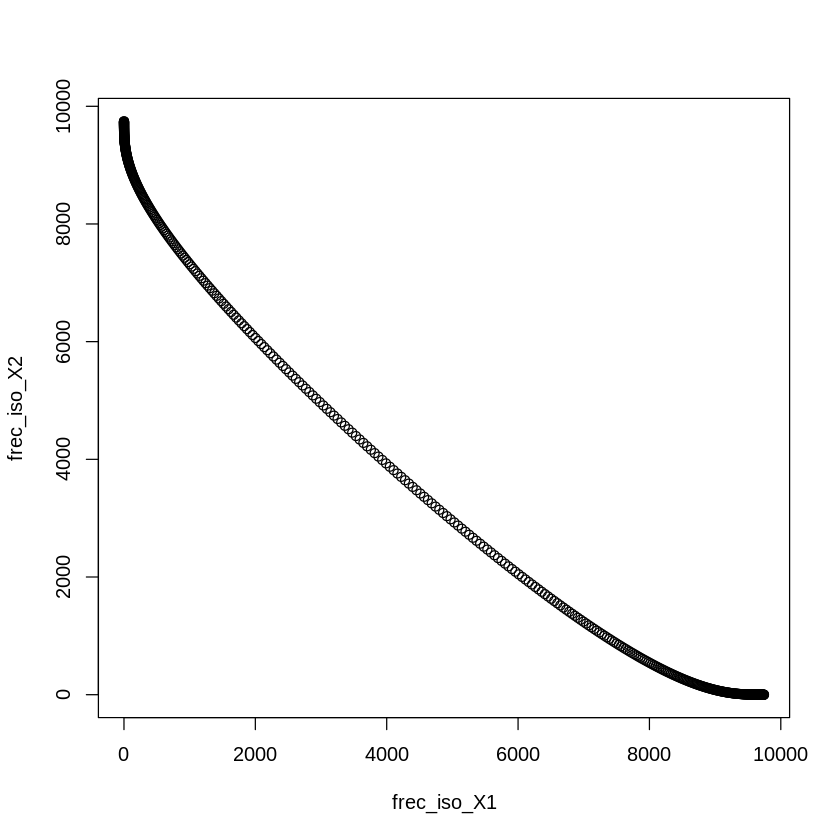

In [58]:
plot(frec_iso_X1, frec_iso_X2)

## Coverage Results

In [6]:
results <- readRDS('/pscratch/sd/j/jbbutler/sims/regions/mixed_coverage/bivtcopula_frecmargins/full_coverage_res.RData')

In [7]:
#results$is_inf <- results$frec_distance == Inf
res <- results %>% 
group_by(n, alpha, p, beta_func) %>% 
summarize(covrate=mean(covered))

`summarise()` has grouped output by 'n', 'alpha', 'p'. You can override using
the `.groups` argument.


In [4]:
res

n,alpha,p,beta_func,covrate
<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1e+03,0.01,5e-03,0.5,1.000
1e+03,0.05,5e-03,0.5,1.000
1e+03,0.10,5e-03,0.5,1.000
5e+03,0.01,5e-03,0.5,1.000
5e+03,0.05,5e-03,0.5,1.000
5e+03,0.10,5e-03,0.5,1.000
1e+04,0.01,1e-04,0.5,1.000
1e+04,0.01,5e-03,0.5,1.000
1e+04,0.05,1e-04,0.5,1.000


In [11]:
library(knitr)
res %>% filter(p==0.005, alpha==0.05) %>% ungroup() %>% select(n, covrate)

n,covrate
<dbl>,<dbl>
1e+03,1
5e+03,1
1e+04,1
5e+04,1
1e+05,1


In [45]:
res %>% filter(p==0.0001, alpha==0.05) %>% select(n, covrate, avg_frec_dist, prop_upper_bounded)

n,covrate,avg_frec_dist,prop_upper_bounded
<dbl>,<dbl>,<dbl>,<dbl>
1e+04,1,Inf,0
5e+04,1,Inf,0
1e+05,1,Inf,0


Wow, this is really conservative

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


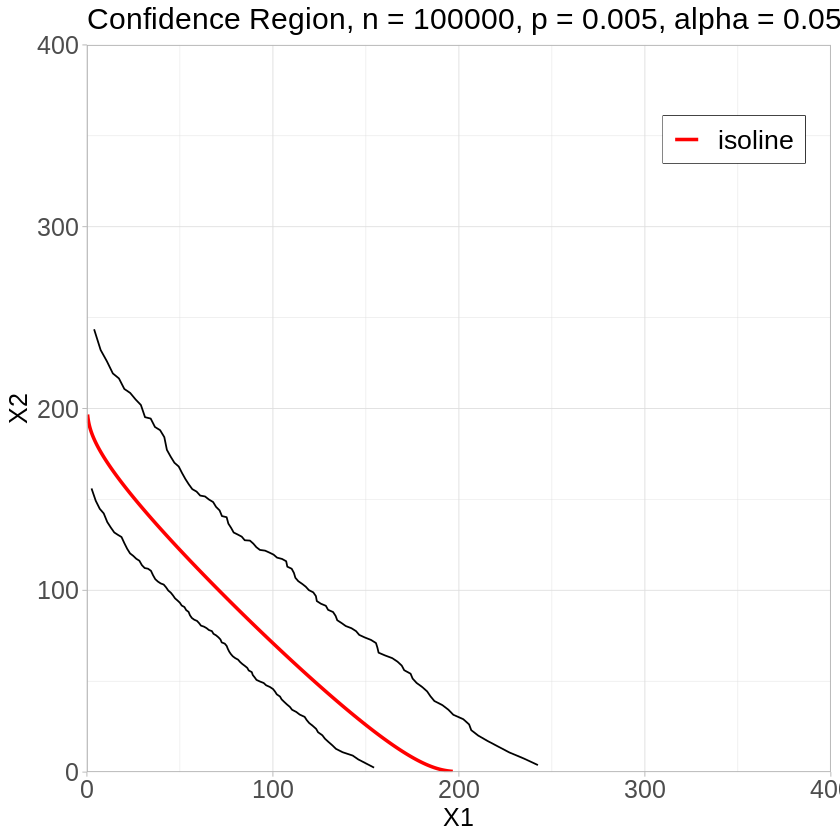

In [50]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/0.005_prob/1e+05_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)

confreg_lab <- 'beta0.5_p0.005_alpha0.05'

frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.005)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))
isoline <- data.frame(X1=frec_iso_X1, X2=frec_iso_X2)

n <- nrow(confregs$data)
p <- confregs[[confreg_lab]]$p
alpha <- confregs[[confreg_lab]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
geom_line(data=frec_top, aes(x=X1, y=X2)) +
geom_line(data=frec_bottom, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,400), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,400), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

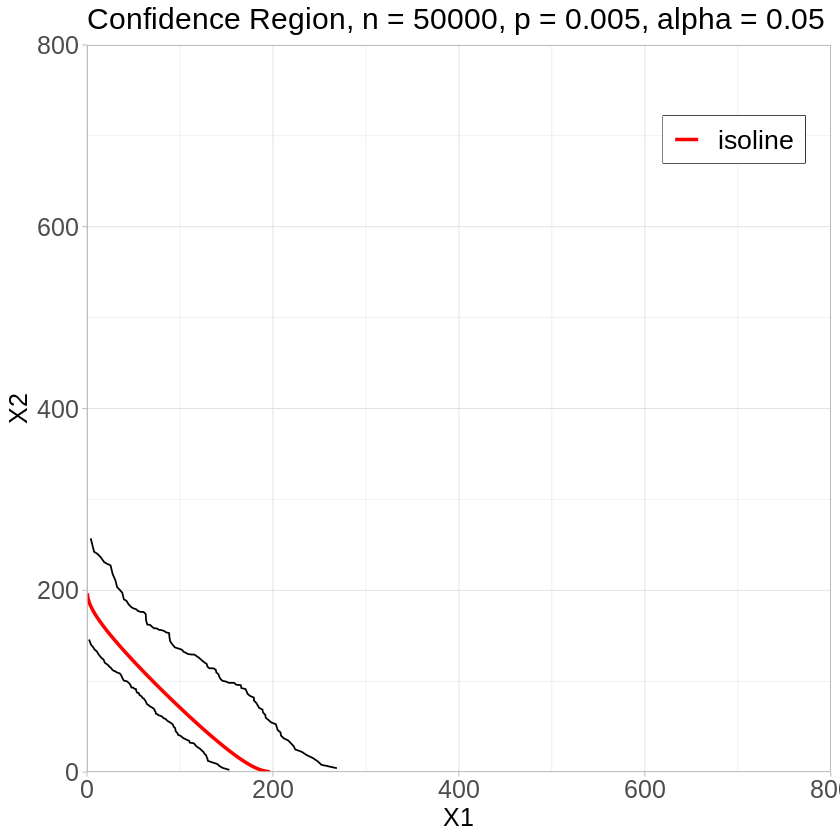

In [51]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/0.005_prob/50000_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)

confreg_lab <- 'beta0.5_p0.005_alpha0.05'

frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.005)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))
isoline <- data.frame(X1=frec_iso_X1, X2=frec_iso_X2)

n <- nrow(confregs$data)
p <- confregs[[confreg_lab]]$p
alpha <- confregs[[confreg_lab]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
geom_line(data=frec_top, aes(x=X1, y=X2)) +
geom_line(data=frec_bottom, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,800), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,800), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

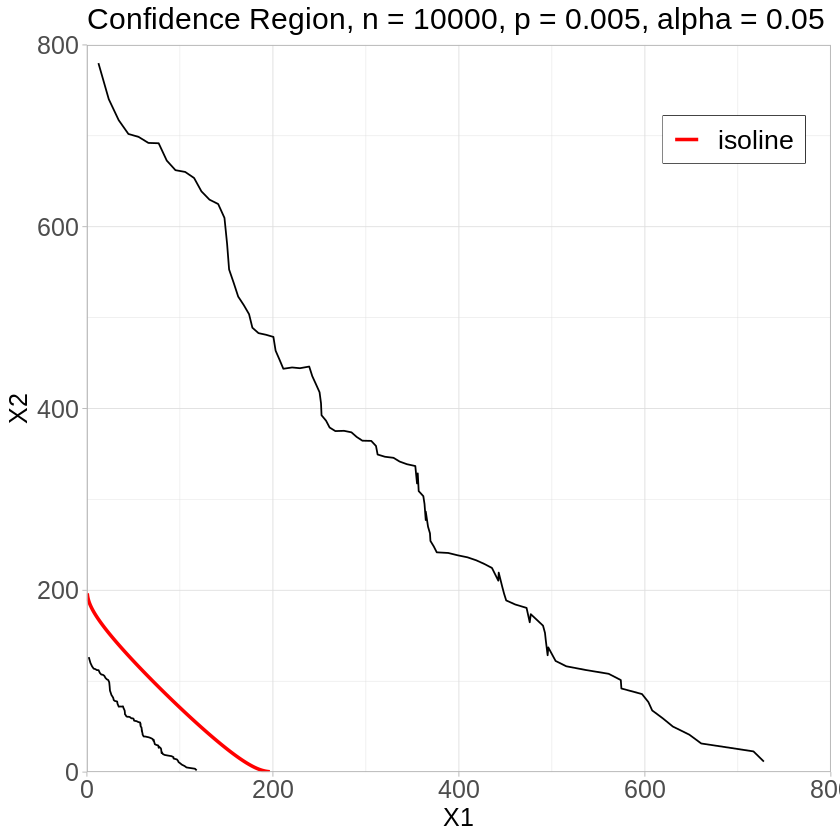

In [52]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/0.005_prob/10000_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)

confreg_lab <- 'beta0.5_p0.005_alpha0.05'

frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.005)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))
isoline <- data.frame(X1=frec_iso_X1, X2=frec_iso_X2)

n <- nrow(confregs$data)
p <- confregs[[confreg_lab]]$p
alpha <- confregs[[confreg_lab]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
geom_line(data=frec_top, aes(x=X1, y=X2)) +
geom_line(data=frec_bottom, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,800), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,800), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

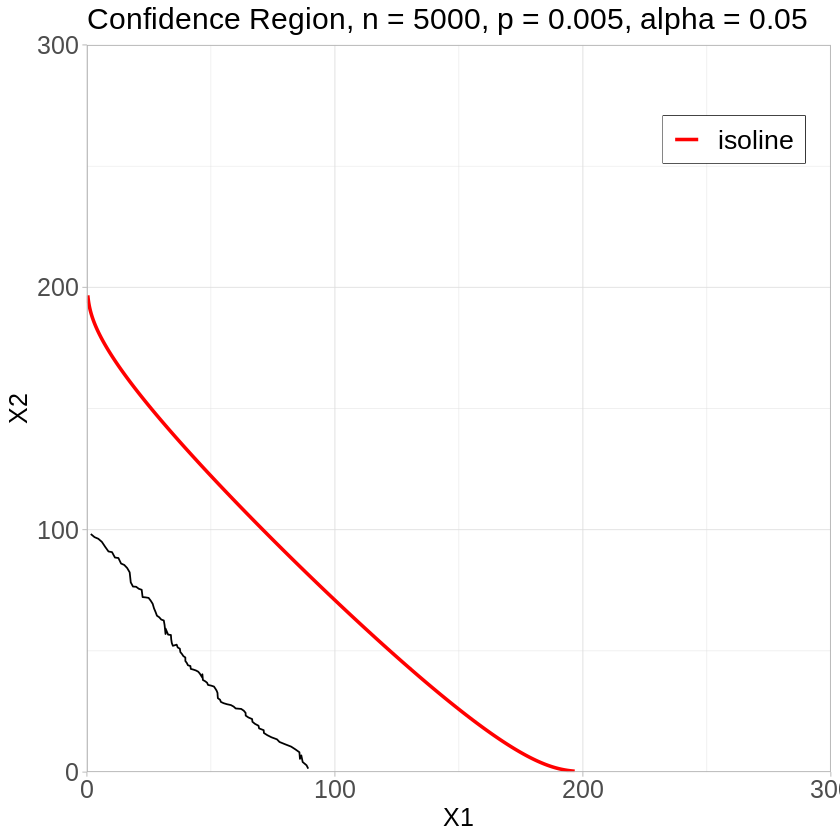

In [20]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/0.005_prob/5000_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)

confreg_lab <- 'beta0.5_p0.005_alpha0.05'

#frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.005)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))
isoline <- data.frame(X1=frec_iso_X1, X2=frec_iso_X2)

n <- nrow(confregs$data)
p <- confregs[[confreg_lab]]$p
alpha <- confregs[[confreg_lab]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
#geom_line(data=frec_top, aes(x=X1, y=X2)) +
geom_line(data=frec_bottom, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,300), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,300), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

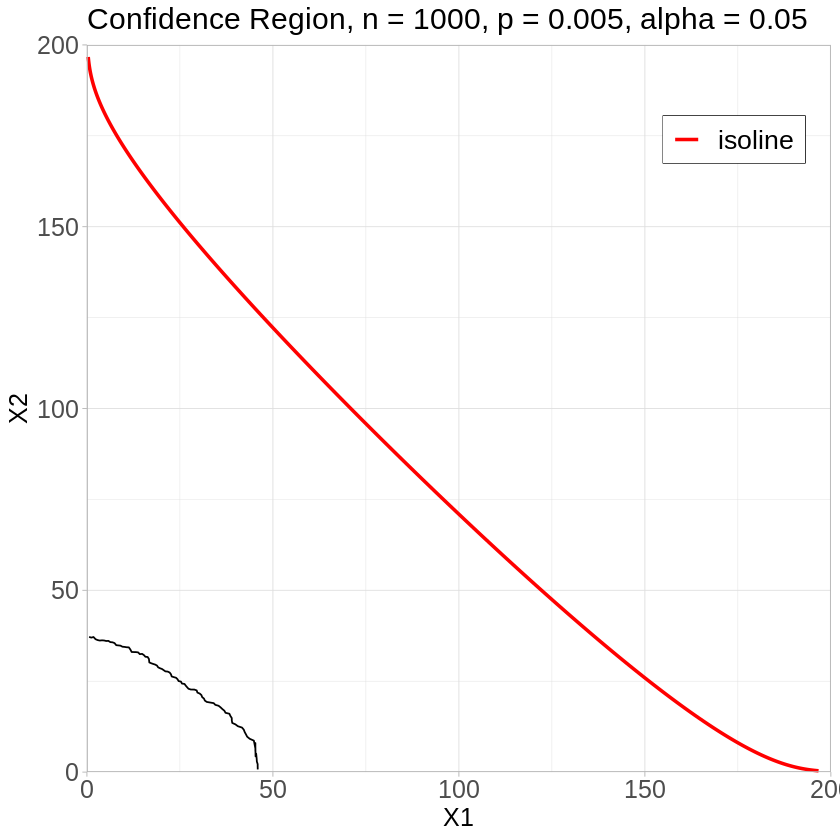

In [21]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/0.005_prob/1000_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)

confreg_lab <- 'beta0.5_p0.005_alpha0.05'

#frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.005)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))
isoline <- data.frame(X1=frec_iso_X1, X2=frec_iso_X2)

n <- nrow(confregs$data)
p <- confregs[[confreg_lab]]$p
alpha <- confregs[[confreg_lab]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
#geom_line(data=frec_top, aes(x=X1, y=X2)) +
geom_line(data=frec_bottom, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,200), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,200), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

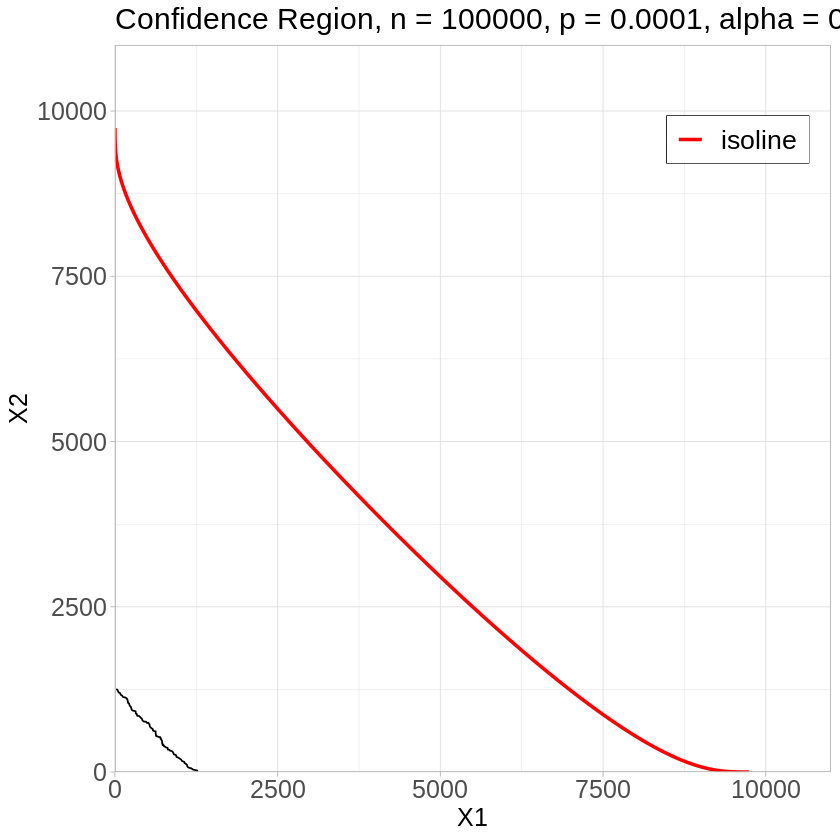

In [35]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/1e-04_prob/1e+05_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)

confreg_lab <- 'beta0.5_p1e-04_alpha0.05'

#frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.0001)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))
isoline <- data.frame(X1=frec_iso_X1, X2=frec_iso_X2)

n <- nrow(confregs$data)
p <- confregs[[confreg_lab]]$p
alpha <- confregs[[confreg_lab]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
#geom_line(data=frec_top, aes(x=X1, y=X2)) +
geom_line(data=frec_bottom, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,11000), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,11000), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

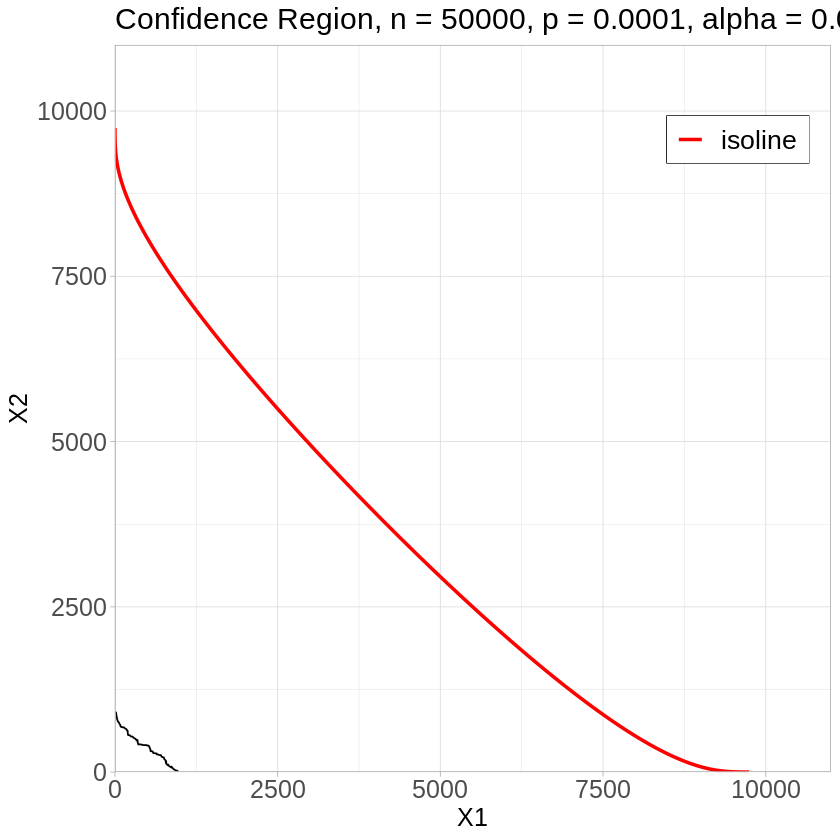

In [53]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/1e-04_prob/50000_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)

confreg_lab <- 'beta0.5_p1e-04_alpha0.05'

#frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.0001)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))
isoline <- data.frame(X1=frec_iso_X1, X2=frec_iso_X2)

n <- nrow(confregs$data)
p <- confregs[[confreg_lab]]$p
alpha <- confregs[[confreg_lab]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
#geom_line(data=frec_top, aes(x=X1, y=X2)) +
geom_line(data=frec_bottom, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,11000), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,11000), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

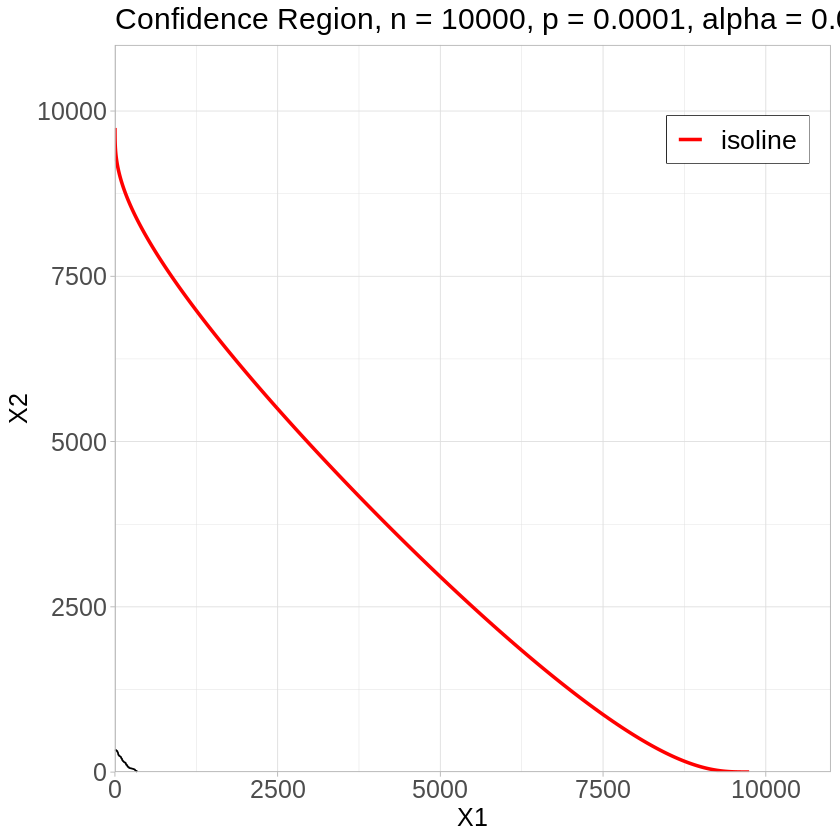

In [54]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/1e-04_prob/10000_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)

confreg_lab <- 'beta0.5_p1e-04_alpha0.05'

#frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.0001)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))
isoline <- data.frame(X1=frec_iso_X1, X2=frec_iso_X2)

n <- nrow(confregs$data)
p <- confregs[[confreg_lab]]$p
alpha <- confregs[[confreg_lab]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
#geom_line(data=frec_top, aes(x=X1, y=X2)) +
geom_line(data=frec_bottom, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,11000), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,11000), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

### Let's compare what some of these confidence intervals look like with empirical survival functions..

In [60]:
source('~/isolines_uq/scripts/R/confidence_regions_procedure/confidenceRegions.R')


Warning message:
“package ‘ks’ was built under R version 4.2.3”
Loading required package: mgcv

Warning message:
“package ‘mgcv’ was built under R version 4.2.3”
Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.

Warning message:
“package ‘MASS’ was built under R version 4.2.3”

Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Warning message:
“package ‘evd’ was built under R version 4.2.3”
Warning message:
“package ‘chron’ was built under R version 4.2.3”


In [92]:
ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/0.005_prob/5000_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)

confreg_lab <- 'beta0.5_p0.005_alpha0.05'

dat <- confregs$data

lbs <- c(0, 0)
ubs <- c(400, 400)
gticks <- 400 
grid <- expand.grid(X1 = seq(lbs[1], ubs[1], length.out = gticks),
                    X2 = seq(lbs[2], ubs[2], length.out = gticks))

grid_obj <- list()
grid_obj$lbs <- lbs
grid_obj$ubs <- ubs
grid_obj$grid <- grid

beta_funcs_dict <- list()
beta_funcs_dict[[as.character(1/2)]] <- function(n) {return((1/n)^(1/2))}

base_out <- drawBaseRegions(dat, grid_obj, lbs, ubs, alphas = c(0.05), ps = c(0.005), B=500, beta_funcs_dict=beta_funcs_dict)

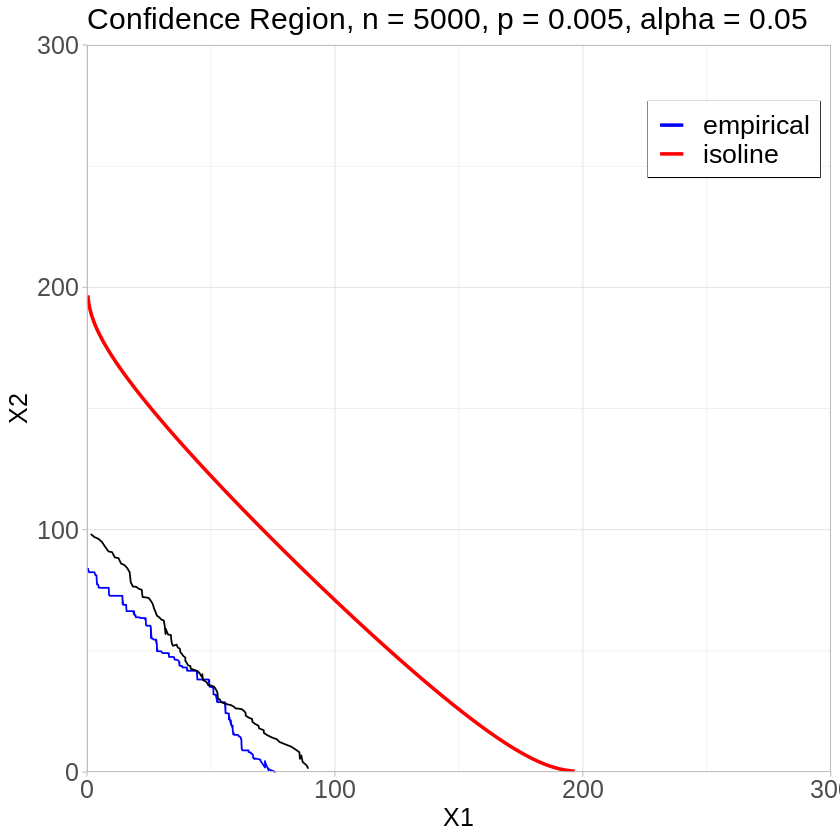

In [95]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

#frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom_frechet <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

#frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom_empirical <- base_out[[1]]$tube_bottom


isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.005)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))
isoline <- data.frame(X1=frec_iso_X1, X2=frec_iso_X2)

n <- nrow(base_out$data)
p <- base_out[[1]]$p
alpha <- base_out[[1]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
#geom_line(data=frec_top, aes(x=X1, y=X2)) +
geom_line(data=frec_bottom_empirical, aes(x=X1, y=X2, color='empirical')) +
geom_line(data=frec_bottom_frechet, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,300), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,300), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red', 'empirical'='blue')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

In [83]:
ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/0.005_prob/10000_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)

confreg_lab <- 'beta0.5_p0.005_alpha0.05'

dat <- confregs$data

lbs <- c(0, 0)
ubs <- c(400, 400)
gticks <- 400 
grid <- expand.grid(X1 = seq(lbs[1], ubs[1], length.out = gticks),
                    X2 = seq(lbs[2], ubs[2], length.out = gticks))

grid_obj <- list()
grid_obj$lbs <- lbs
grid_obj$ubs <- ubs
grid_obj$grid <- grid

beta_funcs_dict <- list()
beta_funcs_dict[[as.character(1/2)]] <- function(n) {return((1/n)^(1/2))}

base_out <- drawBaseRegions(dat, grid_obj, lbs, ubs, alphas = c(0.05), ps = c(0.005), B=500, beta_funcs_dict=beta_funcs_dict)

Warning message:
“Removed 13 rows containing missing values (`geom_line()`).”


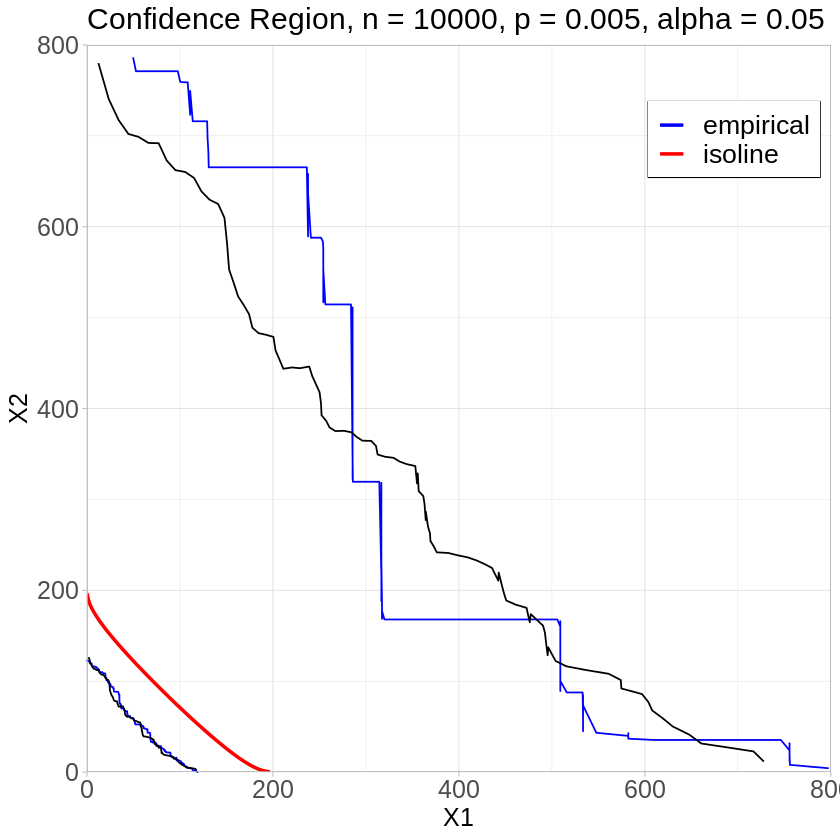

In [91]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

frec_top_frechet <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom_frechet <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

frec_top_empirical <- base_out[[1]]$tube_top
frec_bottom_empirical <- base_out[[1]]$tube_bottom


isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.005)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))
isoline <- data.frame(X1=frec_iso_X1, X2=frec_iso_X2)

n <- nrow(base_out$data)
p <- base_out[[1]]$p
alpha <- base_out[[1]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
geom_line(data=frec_top_empirical, aes(x=X1, y=X2, color='empirical')) +
geom_line(data=frec_top_frechet, aes(x=X1, y=X2)) +
geom_line(data=frec_bottom_empirical, aes(x=X1, y=X2, color='empirical')) +
geom_line(data=frec_bottom_frechet, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,800), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,800), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red', 'empirical'='blue')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

In [96]:
ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/0.005_prob/50000_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)

confreg_lab <- 'beta0.5_p0.005_alpha0.05'

dat <- confregs$data

lbs <- c(0, 0)
ubs <- c(400, 400)
gticks <- 400 
grid <- expand.grid(X1 = seq(lbs[1], ubs[1], length.out = gticks),
                    X2 = seq(lbs[2], ubs[2], length.out = gticks))

grid_obj <- list()
grid_obj$lbs <- lbs
grid_obj$ubs <- ubs
grid_obj$grid <- grid

beta_funcs_dict <- list()
beta_funcs_dict[[as.character(1/2)]] <- function(n) {return((1/n)^(1/2))}

base_out <- drawBaseRegions(dat, grid_obj, lbs, ubs, alphas = c(0.05), ps = c(0.005), B=500, beta_funcs_dict=beta_funcs_dict)

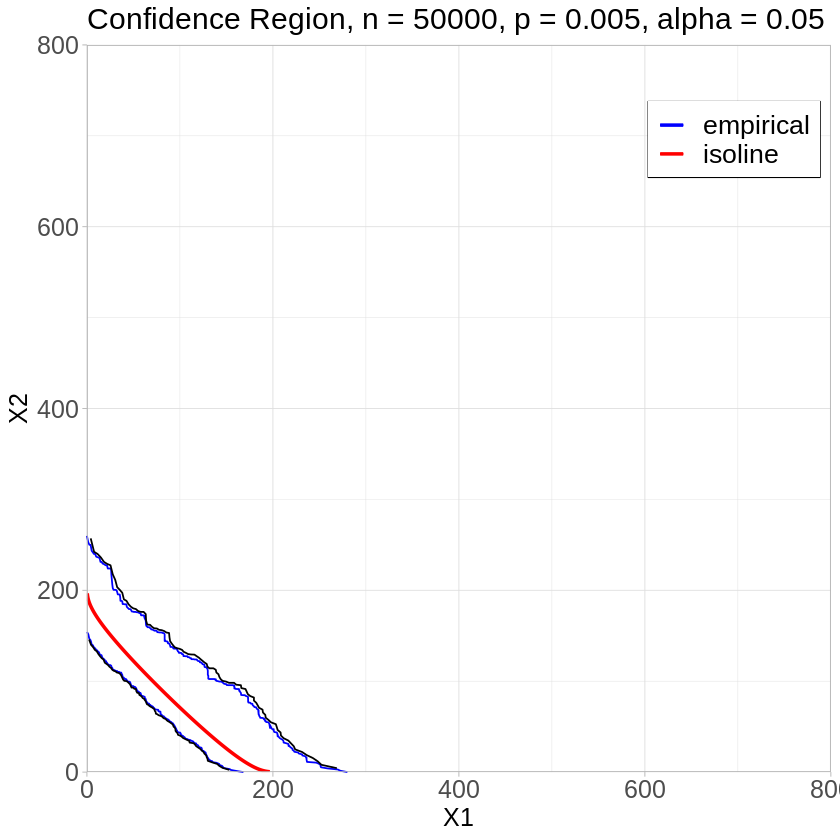

In [97]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

frec_top_frechet <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom_frechet <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

frec_top_empirical <- base_out[[1]]$tube_top
frec_bottom_empirical <- base_out[[1]]$tube_bottom


isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.005)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))
isoline <- data.frame(X1=frec_iso_X1, X2=frec_iso_X2)

n <- nrow(base_out$data)
p <- base_out[[1]]$p
alpha <- base_out[[1]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
geom_line(data=frec_top_empirical, aes(x=X1, y=X2, color='empirical')) +
geom_line(data=frec_top_frechet, aes(x=X1, y=X2)) +
geom_line(data=frec_bottom_empirical, aes(x=X1, y=X2, color='empirical')) +
geom_line(data=frec_bottom_frechet, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,800), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,800), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red', 'empirical'='blue')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

In [98]:
ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/1e-04_prob/10000_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)

confreg_lab <- 'beta0.5_p1e-04_alpha0.05'

dat <- confregs$data

lbs <- c(0, 0)
ubs <- c(10000, 10000)
gticks <- 400 
grid <- expand.grid(X1 = seq(lbs[1], ubs[1], length.out = gticks),
                    X2 = seq(lbs[2], ubs[2], length.out = gticks))

grid_obj <- list()
grid_obj$lbs <- lbs
grid_obj$ubs <- ubs
grid_obj$grid <- grid

beta_funcs_dict <- list()
beta_funcs_dict[[as.character(1/2)]] <- function(n) {return((1/n)^(1/2))}

base_out <- drawBaseRegions(dat, grid_obj, lbs, ubs, alphas = c(0.05), ps = c(0.0001), B=500, beta_funcs_dict=beta_funcs_dict)

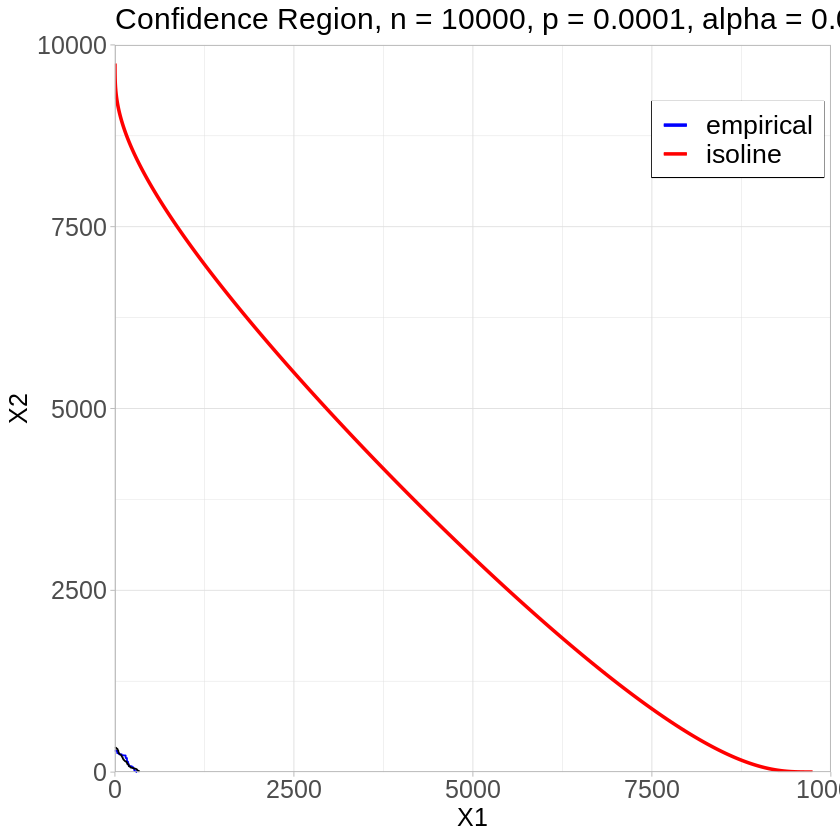

In [102]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

#frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom_frechet <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

#frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom_empirical <- base_out[[1]]$tube_bottom


isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.0001)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))
isoline <- data.frame(X1=frec_iso_X1, X2=frec_iso_X2)

n <- nrow(base_out$data)
p <- base_out[[1]]$p
alpha <- base_out[[1]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
#geom_line(data=frec_top, aes(x=X1, y=X2)) +
geom_line(data=frec_bottom_empirical, aes(x=X1, y=X2, color='empirical')) +
geom_line(data=frec_bottom_frechet, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,10000), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,10000), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red', 'empirical'='blue')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

In [103]:
ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/1e-04_prob/50000_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)

confreg_lab <- 'beta0.5_p1e-04_alpha0.05'

dat <- confregs$data

lbs <- c(0, 0)
ubs <- c(10000, 10000)
gticks <- 400 
grid <- expand.grid(X1 = seq(lbs[1], ubs[1], length.out = gticks),
                    X2 = seq(lbs[2], ubs[2], length.out = gticks))

grid_obj <- list()
grid_obj$lbs <- lbs
grid_obj$ubs <- ubs
grid_obj$grid <- grid

beta_funcs_dict <- list()
beta_funcs_dict[[as.character(1/2)]] <- function(n) {return((1/n)^(1/2))}

base_out <- drawBaseRegions(dat, grid_obj, lbs, ubs, alphas = c(0.05), ps = c(0.0001), B=500, beta_funcs_dict=beta_funcs_dict)

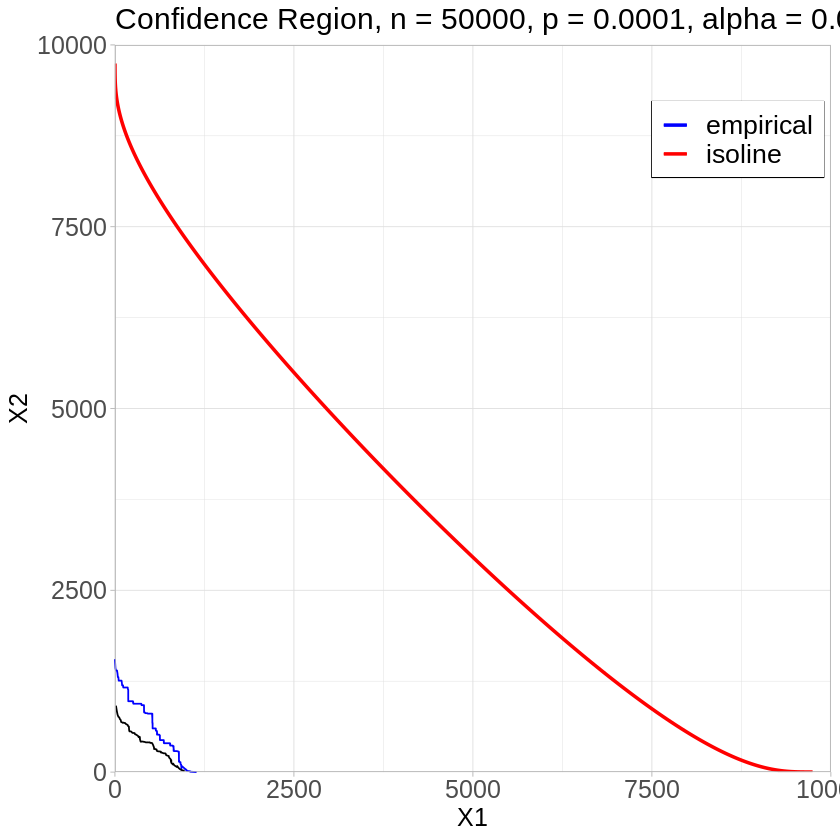

In [104]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

#frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom_frechet <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

#frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom_empirical <- base_out[[1]]$tube_bottom


isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.0001)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))
isoline <- data.frame(X1=frec_iso_X1, X2=frec_iso_X2)

n <- nrow(base_out$data)
p <- base_out[[1]]$p
alpha <- base_out[[1]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
#geom_line(data=frec_top, aes(x=X1, y=X2)) +
geom_line(data=frec_bottom_empirical, aes(x=X1, y=X2, color='empirical')) +
geom_line(data=frec_bottom_frechet, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,10000), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,10000), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red', 'empirical'='blue')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))

In [108]:
ind <- 40
path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/mixed_confregs/bivtcopula_frecmargins/1e-04_prob/1e+05_samples/simulation_', ind,'.RData')
confregs <- readRDS(path)

confreg_lab <- 'beta0.5_p1e-04_alpha0.05'

dat <- confregs$data

lbs <- c(0, 0)
ubs <- c(10000, 10000)
gticks <- 400 
grid <- expand.grid(X1 = seq(lbs[1], ubs[1], length.out = gticks),
                    X2 = seq(lbs[2], ubs[2], length.out = gticks))

grid_obj <- list()
grid_obj$lbs <- lbs
grid_obj$ubs <- ubs
grid_obj$grid <- grid

beta_funcs_dict <- list()
beta_funcs_dict[[as.character(1/2)]] <- function(n) {return((1/n)^(1/2))}

base_out <- drawBaseRegions(dat, grid_obj, lbs, ubs, alphas = c(0.05), ps = c(0.0001), B=500, beta_funcs_dict=beta_funcs_dict)

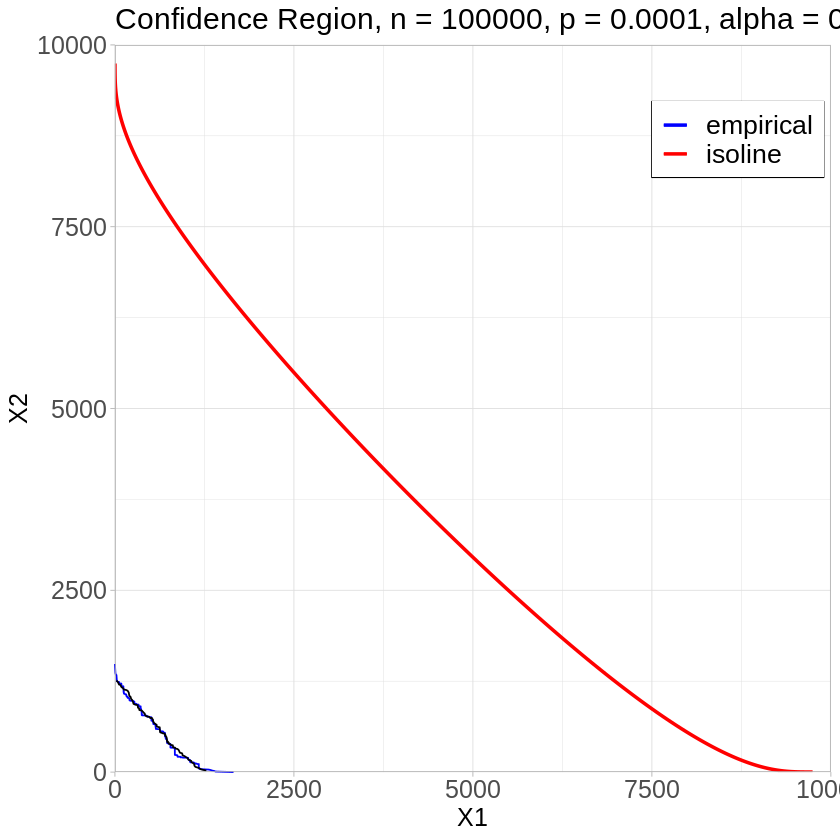

In [109]:
options(repr.plot.width=7, repr.plot.height=7, scipen=999)

#frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom_frechet <- confregs[[confreg_lab]]$tube_bounds$bottom[-c(1, 100),c(1,2)]

#frec_top <- confregs[[confreg_lab]]$tube_bounds$top[-c(1, 100),c(1,2)]
frec_bottom_empirical <- base_out[[1]]$tube_bottom


isoline <- drawBivtIsoline(numCoords=500, gridUbs=c(100,100), gridLbs=c(-2,-2), prob=0.0001)
frec_iso_X1 <- -1/log(pt(isoline$X1, df=4))
frec_iso_X2 <- -1/log(pt(isoline$X2, df=4))
isoline <- data.frame(X1=frec_iso_X1, X2=frec_iso_X2)

n <- nrow(base_out$data)
p <- base_out[[1]]$p
alpha <- base_out[[1]]$alpha

ggplot() + 
#geom_point(data=confregs$data, aes(x=X1, y=X2), alpha=0.1) + 
#geom_line(data=frec_top, aes(x=X1, y=X2)) +
geom_line(data=frec_bottom_empirical, aes(x=X1, y=X2, color='empirical')) +
geom_line(data=frec_bottom_frechet, aes(x=X1, y=X2)) +
#geom_polygon(data=polygon, aes(x=X1, y=X2, fill='region'), alpha=0.2) +
geom_line(data=isoline, aes(x=X1, y=X2, color='isoline'), size=1) +
scale_x_continuous(limits = c(0,10000), expand = c(0, 0)) +
scale_y_continuous(limits = c(0,10000), expand = c(0, 0)) +
scale_fill_manual(values=c('region'='blue')) +
scale_color_manual(values=c('isoline'='red', 'empirical'='blue')) +
ggtitle(paste0('Confidence Region, n = ', n, ', p = ', p, ', alpha = ', alpha)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
      legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 15), 
      axis.text = element_text(size = 15), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20),
      plot.title = element_text(size=18))